In [ ]:
!pip install pmdarima
!pip install prophet
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.tsa as tsa
import statsmodels as sm
from scipy.stats import boxcox
from datetime import datetime
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import pmdarima as pm
from prophet import Prophet

In [ ]:

importacion = pd.read_excel("/content/IMPORTACION-VOLUMEN-2023-05.xlsx", skiprows=6)
precio = pd.read_excel("/content/Precios-Mensuales-promedio-combustibles-Ciudad-de-Guatemala-mayo-2023-AUTOSERVICIO.xlsx", skiprows=22)
consumo = pd.read_excel("/content/CONSUMO-2023-05.xlsx", skiprows=6)

In [ ]:
precio_s = precio.iloc[0:12,:]

In [ ]:
precio_s

,MES/AÑO,2001,2002,2003,2004,2005,2006,2007,2008,2009,...,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
0,ENERO,14.13,12.55,15.34,15.90,18.80,22.33,22.67,28.53,21.17,...,34.06,20.90,19.54,23.86,24.93,22.17,24.75,22.74,30.38,34.10
1,FEBRERO,14.33,12.29,16.22,17.23,18.28,22.03,21.66,28.35,20.90,...,33.14,22.44,18.56,23.04,24.89,23.00,23.67,24.45,32.95,34.06
2,MARZO,14.13,12.58,17.41,17.85,19.46,21.84,22.87,29.73,20.52,...,33.62,24.19,20.24,22.57,24.91,24.94,22.62,26.62,38.25,33.40
3,ABRIL,14.04,14.11,16.49,18.29,21.70,24.15,25.28,31.41,21.16,...,34.32,24.75,21.47,23.35,26.21,26.95,17.89,26.92,37.86,35.34
4,MAYO,15.34,14.16,15.44,18.59,22.23,26.62,27.29,32.77,22.44,...,33.81,26.06,22.32,22.73,27.43,27.00,17.67,27.80,41.25,33.91
5,JUNIO,15.32,13.96,14.57,18.90,21.96,26.45,28.41,35.17,25.17,...,34.62,26.30,22.86,22.43,27.06,25.55,20.04,27.87,40.74,NaN
6,JULIO,14.67,14.43,14.62,18.87,21.93,26.30,28.09,36.06,26.06,...,34.81,26.37,21.72,22.26,26.99,26.23,21.50,28.46,35.69,NaN
7,AGOSTO,13.89,15.29,15.14,18.71,22.61,27.86,27.52,35.41,26.16,...,34.03,24.37,21.54,22.84,27.06,25.16,21.21,28.91,35.28,NaN
8,SEPTIEMBRE,14.00,15.25,16.55,18.60,25.21,26.97,26.78,34.45,26.28,...,32.31,22.42,22.17,24.42,27.31,24.98,21.08,29.19,34.69,NaN
9,OCTUBRE,13.95,15.63,16.27,19.20,26.85,24.45,27.02,30.77,25.57,...,30.49,22.00,22.54,23.55,27.66,24.72,21.15,29.99,36.92,NaN


In [ ]:
# Derretir el dataframe para combinar las columnas de Año en una sola columna 'Año' y los valores en una columna 'Precio'
superp = pd.melt(precio_s, id_vars=['MES/AÑO'], var_name='Año', value_name='Precio')

# Convertir la columna 'Año' de número a string
superp['Año'] = superp['Año'].astype(str)

# Combinar la columna de Mes y Año para formar la columna de fecha
superp['Fecha'] = superp['MES/AÑO'] + ' ' + superp['Año']

# Eliminar las columnas de Mes y Año originales
superp.drop(columns=['MES/AÑO', "Año"], inplace=True)

# Imprimir el resultado
superp


,Precio,Fecha
0,14.13,ENERO 2001
1,14.33,FEBRERO 2001
2,14.13,MARZO 2001
3,14.04,ABRIL 2001
4,15.34,MAYO 2001
...,...,...
271,NaN,AGOSTO 2023
272,NaN,SEPTIEMBRE 2023
273,NaN,OCTUBRE 2023
274,NaN,NOVIEMBRE 2023


In [ ]:
def convertir_fecha(fecha_str):
    meses = {
        "ENERO": 1, "FEBRERO": 2, "MARZO": 3, "ABRIL": 4, "MAYO": 5, "JUNIO": 6,
        "JULIO": 7, "AGOSTO": 8, "SEPTIEMBRE": 9, "OCTUBRE": 10, "NOVIEMBRE": 11, "DICIEMBRE": 12
    }
    mes, año = fecha_str.split(" ")
    mes_num = meses[mes]
    return pd.to_datetime(f"{mes_num}-{año}", format="%m-%Y")


In [ ]:
superp["Fecha"] = superp["Fecha"].apply(convertir_fecha)

In [ ]:
superp.dtypes

Precio           float64
Fecha     datetime64[ns]
dtype: object

In [ ]:
superi = importacion.iloc[0:269,[0,11]]
superc = consumo.iloc[0:269,[0,11]]

superi["Fecha"] = pd.to_datetime(superi["Fecha"], format = "%Y-%m-%d")
superc["Fecha"] = pd.to_datetime(superc["Fecha"], format = "%Y-%m-%d")
superi


,Fecha,Gasolina superior
0,2001-01-01,373963.96
1,2001-02-01,243091.07
2,2001-03-01,312084.38
3,2001-04-01,285054.89
4,2001-05-01,300913.67
...,...,...
264,2023-01-01,578792.14
265,2023-02-01,685183.06
266,2023-03-01,633849.05
267,2023-04-01,572201.36


In [ ]:
trainp = superp[0:int(len(superp)*0.7)]
testp = superp[int(len(superp)*0.7):len(superp)]
trainp.loc[trainp["Fecha"].dt.year == 2009, "Precio"] = np.NaN
trainp.loc[(trainp["Fecha"] >= "2008-04-01") & (trainp["Fecha"] <= "2008-12-01"), "Precio"] = np.NaN

trainp['Precio'] = trainp['Precio'].interpolate()
trainp

<ipython-input-120-827ddcb08f30>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trainp['Precio'] = trainp['Precio'].interpolate()


,Precio,Fecha
0,14.13,2001-01-01
1,14.33,2001-02-01
2,14.13,2001-03-01
3,14.04,2001-04-01
4,15.34,2001-05-01
...,...,...
188,22.17,2016-09-01
189,22.54,2016-10-01
190,21.85,2016-11-01
191,22.80,2016-12-01


In [ ]:
superp.set_index("Fecha", inplace=True)
trainp.set_index("Fecha", inplace=True)
testp.set_index("Fecha", inplace=True)

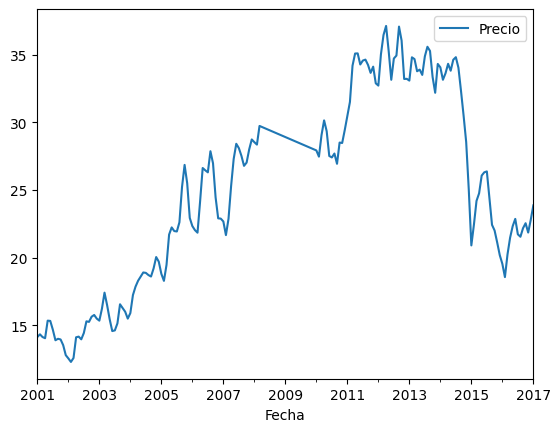

In [ ]:
trainp.plot()
plt.show()

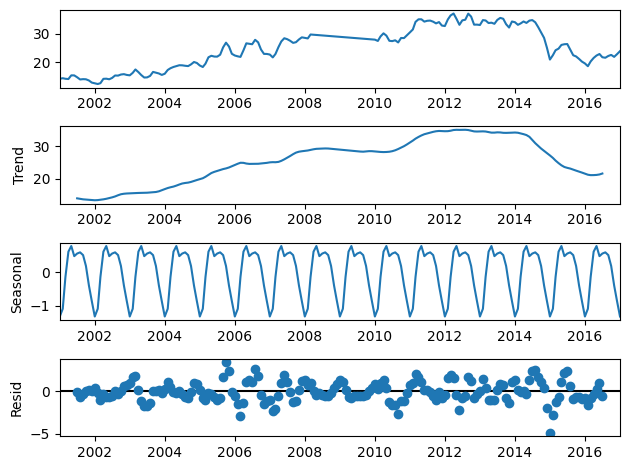

In [ ]:
decomp = seasonal_decompose(trainp, period=12)
decomp.plot()
plt.show()

In [ ]:
dfTestp = adfuller(trainp, autolag="AIC")
salidaDfp = pd.Series(dfTestp[0:4], index=['Estadístico de prueba','p-value','# de retardos usados','# de observaciones usadas'])
for key,value in dfTestp[4].items():
        salidaDfp['Critical Value (%s)'%key] = value
print(salidaDfp)

Estadístico de prueba         -2.057900
p-value                        0.261777
# de retardos usados          11.000000
# de observaciones usadas    181.000000
Critical Value (1%)           -3.467005
Critical Value (5%)           -2.877644
Critical Value (10%)          -2.575355
dtype: float64


In [ ]:
diffp = trainp.diff()
diffp.dropna(inplace=True)
dfTestp = adfuller(diffp)
salidaDfp = pd.Series(dfTestp[0:4], index=['Estadístico de prueba','p-value','# de retardos usados','# de observaciones usadas'])
for key,value in dfTestp[4].items():
        salidaDfp['Critical Value (%s)'%key] = value
print(salidaDfp)

Estadístico de prueba         -3.252899
p-value                        0.017120
# de retardos usados          10.000000
# de observaciones usadas    181.000000
Critical Value (1%)           -3.467005
Critical Value (5%)           -2.877644
Critical Value (10%)          -2.575355
dtype: float64


Se diferenció una vez

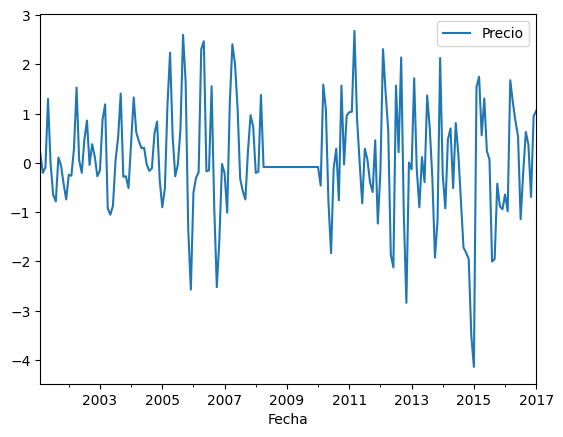

In [ ]:
diffp.plot()
plt.show()

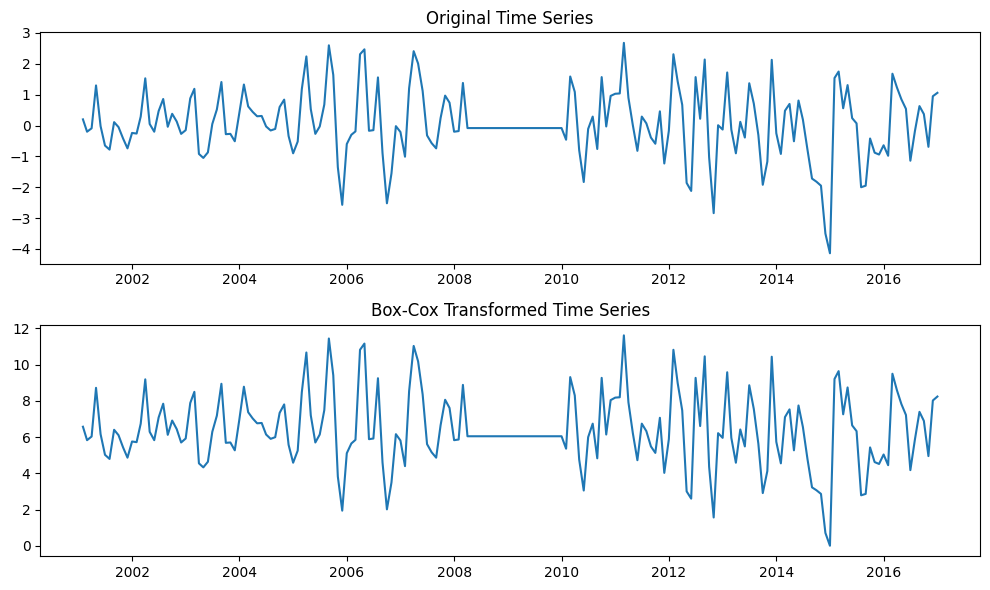

In [ ]:
time_series = diffp['Precio'].values

# Check if any values are non-positive
if np.any(time_series <= 0):
    shift = np.abs(np.min(time_series)) + 1  # Add a small positive constant
    transformed_series = time_series + shift
else:
    transformed_series = time_series

# Apply the Box-Cox transformation to the shifted time series
transformed_data, lambda_param = boxcox(transformed_series)

# Create a new DataFrame to store the transformed data
transformed_df  = pd.DataFrame({'BoxCoxTransformedValue': transformed_data})

# Add the transformed data to the original DataFrame
diffp['BoxCoxTransformedValue'] = transformed_data
plt.figure(figsize=(10, 6))

plt.subplot(2, 1, 1)
plt.plot(diffp['Precio'])
plt.title('Original Time Series')

plt.subplot(2, 1, 2)
plt.plot(diffp['BoxCoxTransformedValue'])
plt.title('Box-Cox Transformed Time Series')

plt.tight_layout()
plt.show()

/usr/local/lib/python3.10/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


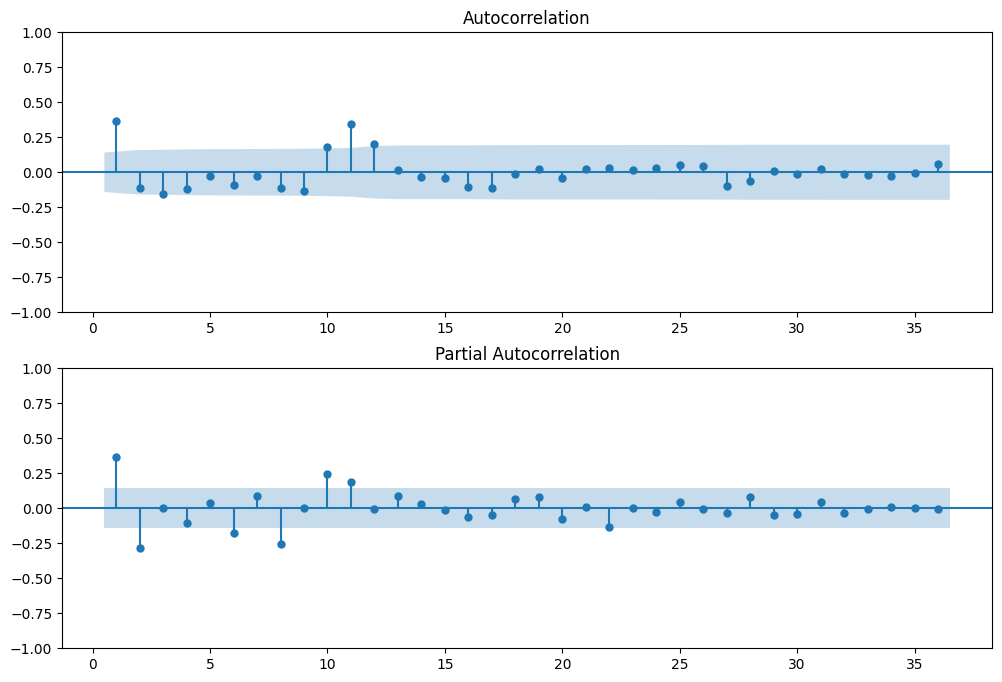

In [ ]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(12,8))

# Plot the ACF of df
plot_acf(diffp, lags=36, zero=False, ax=ax1)

# Plot the PACF of df
plot_pacf(diffp, lags=36, zero=False, ax=ax2)

plt.show()

<Axes: xlabel='Fecha'>

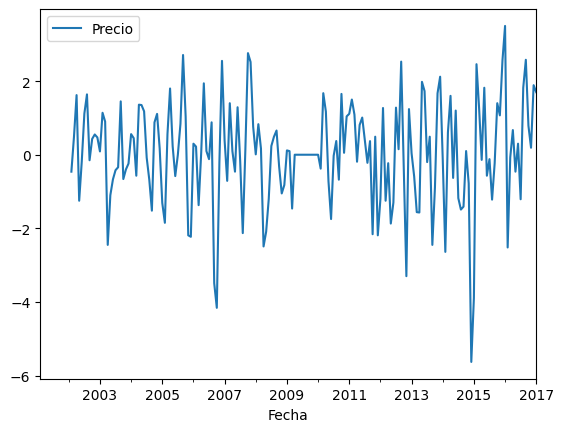

In [ ]:
diffp_ds = diffp.diff(12)
diffp_ds.plot()

/usr/local/lib/python3.10/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


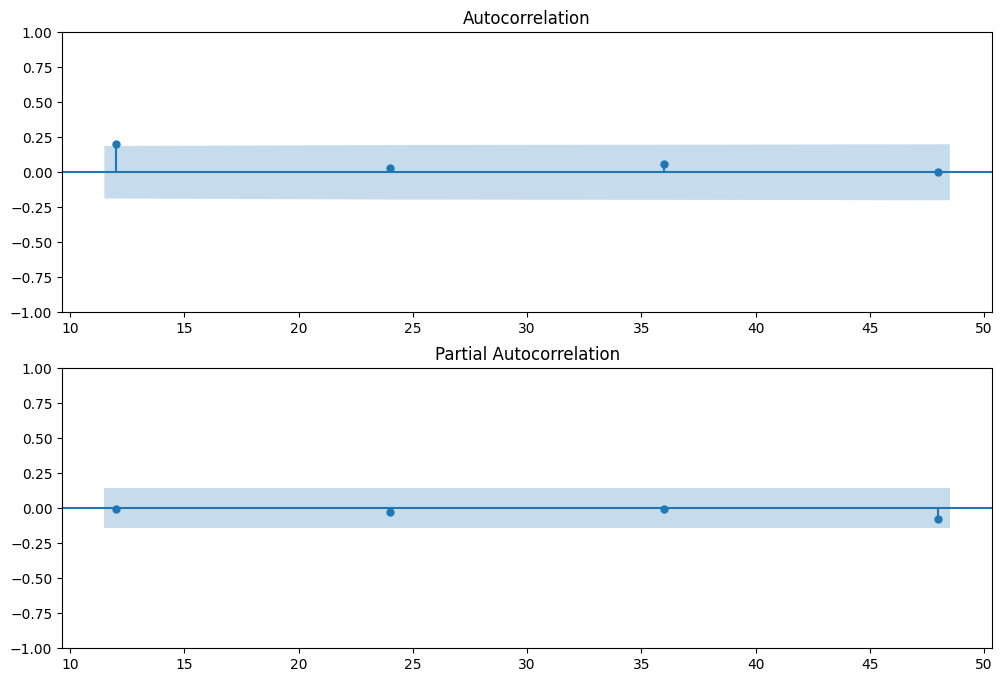

In [ ]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(12,8))

# Plot the ACF of df
plot_acf(diffp, lags=[12,24,36,48], zero=False, ax=ax1)

# Plot the PACF of df
plot_pacf(diffp, lags=[12,24,36,48], zero=False, ax=ax2)

plt.show()

In [ ]:
modelo1p = SARIMAX(trainp, order=(11,1,10), seasonal_order=(1,0,0,12))
resultado1p = modelo1p.fit()
resultado1p.summary()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optim

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                       
=============================================================================================
Dep. Variable:                                Precio   No. Observations:                  193
Model:             SARIMAX(11, 1, 10)x(1, 0, [], 12)   Log Likelihood                -248.088
Date:                               Thu, 10 Aug 2023   AIC                            542.176
Time:                                       01:17:58   BIC                            617.098
Sample:                                   01-01-2001   HQIC                           572.520
                                        - 01-01-2017                                         
Covariance Type:                                 opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1887      3.901      0.048      0.961      -7.458       7.835
ar.L2         -0.3910      1.552     -0.252      0.801      -3.432       2.650
ar.L3          0.1403      2.425      0.058      0.954      -4.613       4.894
ar.L4         -0.1150      0.869     -0.132      0.895      -1.819       1.589
ar.L5         -0.0186      1.078     -0.017      0.986      -2.131       2.094
ar.L6         -0.1117      0.573     -0.195      0.845      -1.235       1.011
ar.L7         -0.1092      0.783     -0.140      0.889      -1.643       1.425
ar.L8          0.1544      0.845      0.183      0.855      -1.502       1.811
ar.L9         -0.1392      0.635     -0.219      0.827      -1.384       1.106
ar.L10         0.2628      1.059      0.248      0.804      -1.813       2.338
ar.L11         0.1140      0.997      0.114      0.909      -1.840       2.068
ma.L1          0.2823      3.901      0.072      0.942      -7.364       7.928
ma.L2          0.2153      1.052      0.205      0.838      -1.847       2.277
ma.L3         -0.0356      1.602     -0.022      0.982      -3.176       3.105
ma.L4         -0.1297      0.735     -0.177      0.860      -1.570       1.310
ma.L5          0.1378      0.607      0.227      0.820      -1.052       1.327
ma.L6         -0.0485      1.153     -0.042      0.966      -2.308       2.211
ma.L7          0.2325      0.633      0.367      0.714      -1.009       1.474
ma.L8         -0.2015      1.408     -0.143      0.886      -2.962       2.559
ma.L9         -0.1220      0.863     -0.141      0.888      -1.813       1.569
ma.L10        -0.0810      0.332     -0.244      0.807      -0.732       0.570
ar.S.L12       0.2175      0.198      1.099      0.272      -0.170       0.605
sigma2         0.7670      0.077      9.979      0.000       0.616       0.918
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 5.73
Prob(Q):                              0.99   Prob(JB):                         0.06
Heteroskedasticity (H):               2.14   Skew:                            -0.16
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.79
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

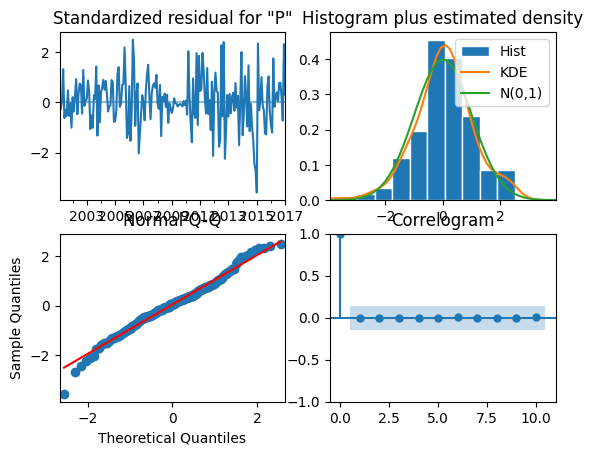

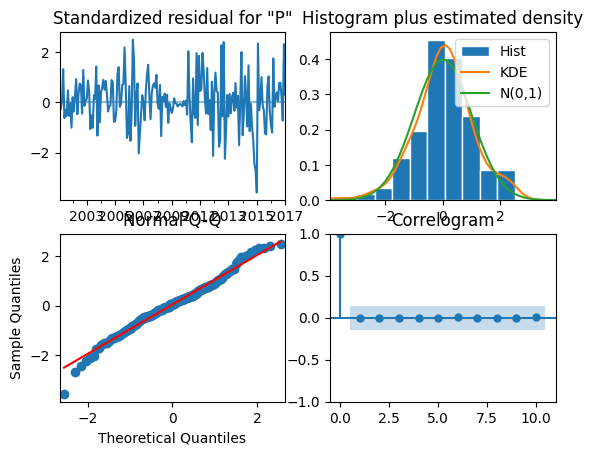

In [ ]:
resultado1p.plot_diagnostics()

In [ ]:
pred1p = resultado1p.get_forecast(start=5)
pred1pvalues = pred1p.predicted_mean
pred1pc = pred1p.conf_int()
pred1pc

,lower Precio,upper Precio
2001-06-01,14.024994,17.838562
2001-07-01,13.049933,16.859329
2001-08-01,12.536358,16.286956
2001-09-01,11.679983,15.413236
2001-10-01,12.632570,16.259620
...,...,...
2016-09-01,19.771853,23.204803
2016-10-01,20.639745,24.072695
2016-11-01,20.771080,24.204029
2016-12-01,19.056452,22.489401


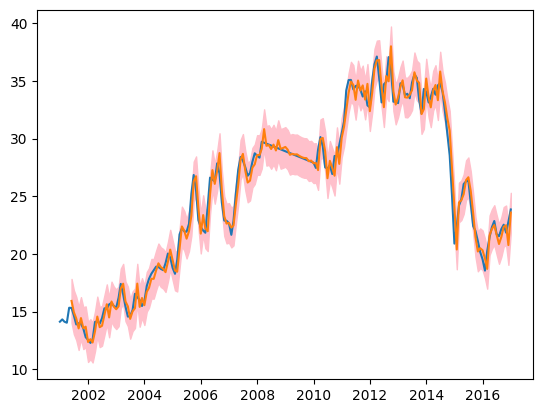

In [ ]:
plt.plot(trainp.index,trainp, label="Train")
#plt.plot(testp.index, testp, label="Test")
plt.plot(pred1pvalues.index, pred1pvalues, label="Model")
plt.fill_between(pred1pc.index, pred1pc["lower Precio"], pred1pc["upper Precio"], color="pink")
plt.show()

In [ ]:
model2p = pm.auto_arima(trainp,
                        d=1,
                        start_p=1,
                        start_q=1,
                        max_p=5,
                        max_q=5,
                        seasonal=True,
                        m=12,
                        D=1,
                        start_P=1,
                        start_Q=1,
                        max_P=5,
                        max_Q=5,
                        information_criterion="aic",
                        trace=True,
                        error_action="ignore",
                        stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=inf, Time=2.50 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=635.416, Time=0.08 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=595.069, Time=0.31 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=1.72 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=627.850, Time=0.10 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=575.457, Time=0.44 sec
 ARIMA(1,1,0)(3,1,0)[12]             : AIC=571.658, Time=1.52 sec
 ARIMA(1,1,0)(4,1,0)[12]             : AIC=566.890, Time=3.36 sec
 ARIMA(1,1,0)(5,1,0)[12]             : AIC=563.325, Time=2.00 sec
 ARIMA(1,1,0)(5,1,1)[12]             : AIC=inf, Time=10.39 sec
 ARIMA(1,1,0)(4,1,1)[12]             : AIC=inf, Time=14.88 sec
 ARIMA(0,1,0)(5,1,0)[12]             : AIC=577.671, Time=1.92 sec
 ARIMA(2,1,0)(5,1,0)[12]             : AIC=551.505, Time=2.80 sec
 ARIMA(2,1,0)(4,1,0)[12]             : AIC=554.760, Time=1.63 sec
 ARIMA(2,1,0)(5,1,1)[12]             : AIC=inf,

                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                  193
Model:             SARIMAX(1, 1, 1)x(5, 1, [], 12)   Log Likelihood                -266.263
Date:                             Wed, 09 Aug 2023   AIC                            548.526
Time:                                     07:11:49   BIC                            574.070
Sample:                                 01-01-2001   HQIC                           558.883
                                      - 01-01-2017                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3989      0.091     -4.408      0.000      -0.576      -0.222
ma.L1          0.8171      

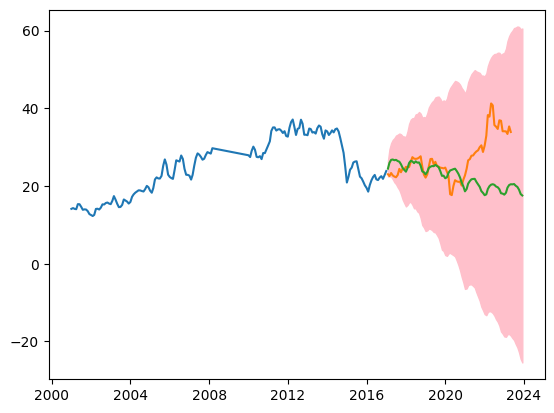

In [ ]:
print(model2p.summary())
#print(model2p.plot_diagnostics())
pred2p, conf_int2p = model2p.predict(n_periods=len(testp), return_conf_int=True)
plt.plot(trainp.index,trainp, label="Train")
plt.plot(testp.index, testp, label="Test")
plt.plot(testp.index, pred2p, label="Model")
plt.fill_between(testp.index, conf_int2p[:,0], conf_int2p[:,1], color="pink")
plt.show()

In [ ]:
trainp2 = trainp.copy()
trainp2.reset_index(inplace=True)
trainp2.rename(columns={"Fecha":"ds", "Precio":"y"}, inplace=True)
trainp2

,ds,y
0,2001-01-01,14.13
1,2001-02-01,14.33
2,2001-03-01,14.13
3,2001-04-01,14.04
4,2001-05-01,15.34
...,...,...
188,2016-09-01,22.17
189,2016-10-01,22.54
190,2016-11-01,21.85
191,2016-12-01,22.80


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7j46xgr1/rj6kmu5o.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7j46xgr1/ezwkraqe.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=32258', 'data', 'file=/tmp/tmp7j46xgr1/rj6kmu5o.json', 'init=/tmp/tmp7j46xgr1/ezwkraqe.json', 'output', 'file=/tmp/tmp7j46xgr1/prophet_modeldbpcvkwh/prophet_model-20230810050608.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
05:06:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
05:06:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


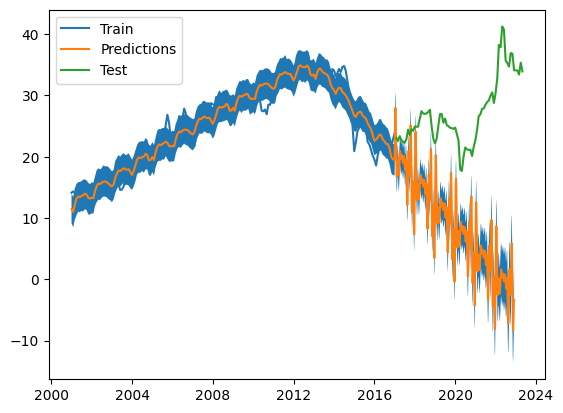

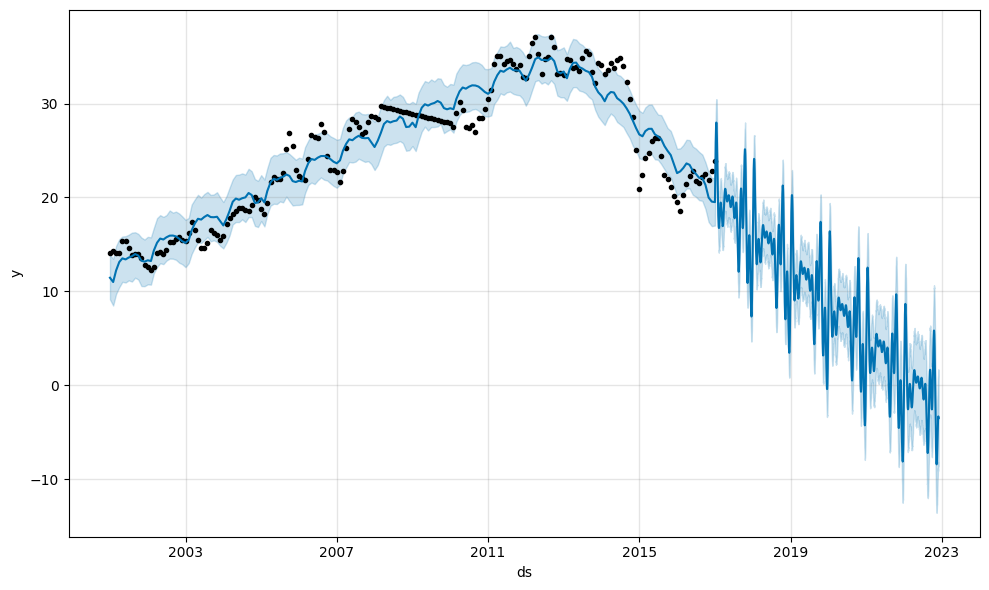

In [ ]:
m = Prophet()
m.fit(trainp2)
futurep = m.make_future_dataframe(periods = 2160)
forecastp = m.predict(futurep)
plt.plot(trainp.index,trainp, label="Train")

plt.plot(forecastp["ds"], forecastp["yhat"], label="Predictions")
plt.fill_between(forecastp["ds"], forecastp["yhat_lower"], forecastp["yhat_upper"])
plt.plot(testp.index, testp, label="Test")
plt.legend()
m.plot(forecastp)
plt.show()

In [ ]:
superi.dtypes
superc.dtypes

Fecha                datetime64[ns]
Gasolina superior           float64
dtype: object

In [ ]:
trainp.tail()

,Precio
Fecha,
2016-09-01,22.17
2016-10-01,22.54
2016-11-01,21.85
2016-12-01,22.80
2017-01-01,23.86


In [ ]:
traini = superi[0:int(len(superi)*0.7)]
testi = superi[int(len(superi)*0.7):len(superi)]
trainc = superc[0:int(len(superc)*0.7)]
testc = superc[int(len(superc)*0.7):len(superc)]


In [ ]:
superi.set_index("Fecha", inplace=True)
traini.set_index("Fecha", inplace=True)
testi.set_index("Fecha", inplace=True)

superc.set_index("Fecha", inplace=True)
trainc.set_index("Fecha", inplace=True)
testc.set_index("Fecha", inplace=True)


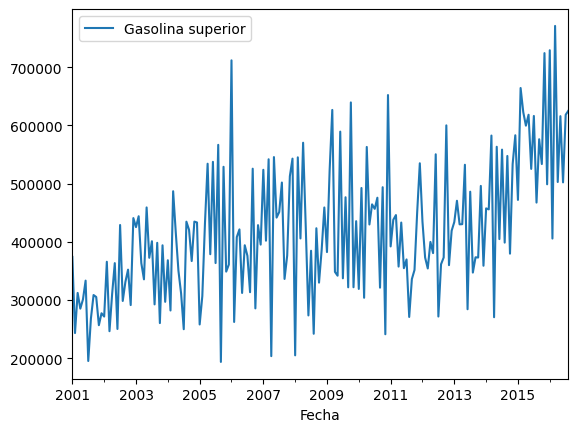

In [ ]:
traini.plot()
plt.show()

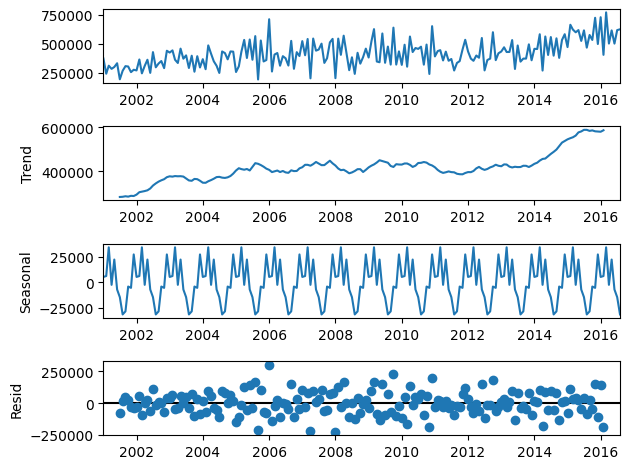

In [ ]:
decompi = seasonal_decompose(traini)
decompi.plot()
plt.show()

In [ ]:
dfTesti = adfuller(traini, autolag="AIC")
salidaDfi = pd.Series(dfTesti[0:4], index=['Estadístico de prueba','p-value','# de retardos usados','# de observaciones usadas'])
for key,value in dfTesti[4].items():
        salidaDfi['Critical Value (%s)'%key] = value
print(salidaDfi)

Estadístico de prueba         -1.690567
p-value                        0.435979
# de retardos usados           5.000000
# de observaciones usadas    182.000000
Critical Value (1%)           -3.466800
Critical Value (5%)           -2.877555
Critical Value (10%)          -2.575308
dtype: float64


In [ ]:
diffi = traini.diff()
diffi.dropna(inplace=True)
dfTesti = adfuller(diffi)
salidaDfi = pd.Series(dfTesti[0:4], index=['Estadístico de prueba','p-value','# de retardos usados','# de observaciones usadas'])
for key,value in dfTesti[4].items():
        salidaDfi['Critical Value (%s)'%key] = value
print(salidaDfi)

Estadístico de prueba       -7.273501e+00
p-value                      1.566068e-10
# de retardos usados         9.000000e+00
# de observaciones usadas    1.770000e+02
Critical Value (1%)         -3.467845e+00
Critical Value (5%)         -2.878012e+00
Critical Value (10%)        -2.575551e+00
dtype: float64


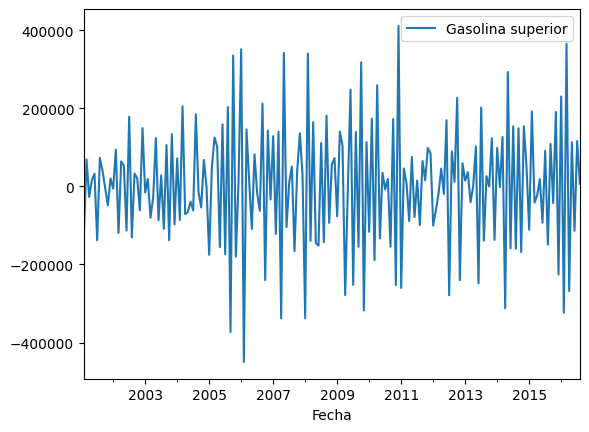

In [ ]:
diffi.plot()
plt.show()

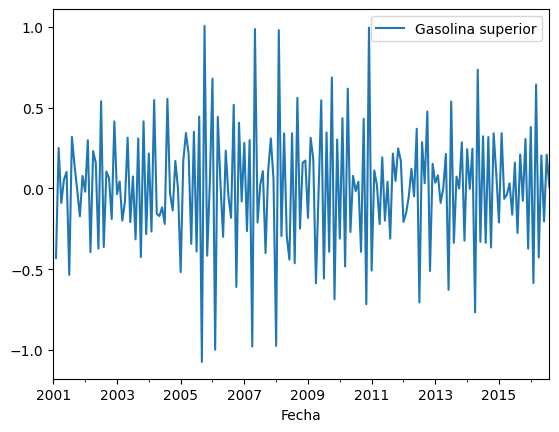

In [ ]:
logtraini = np.log(traini)
diffi2 = logtraini.diff()
diffi2.plot()
plt.show()

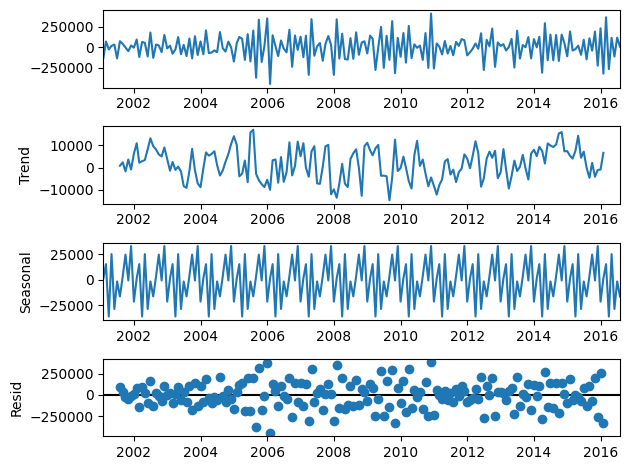

In [ ]:
decompi = seasonal_decompose(diffi)
decompi.plot()
plt.show()

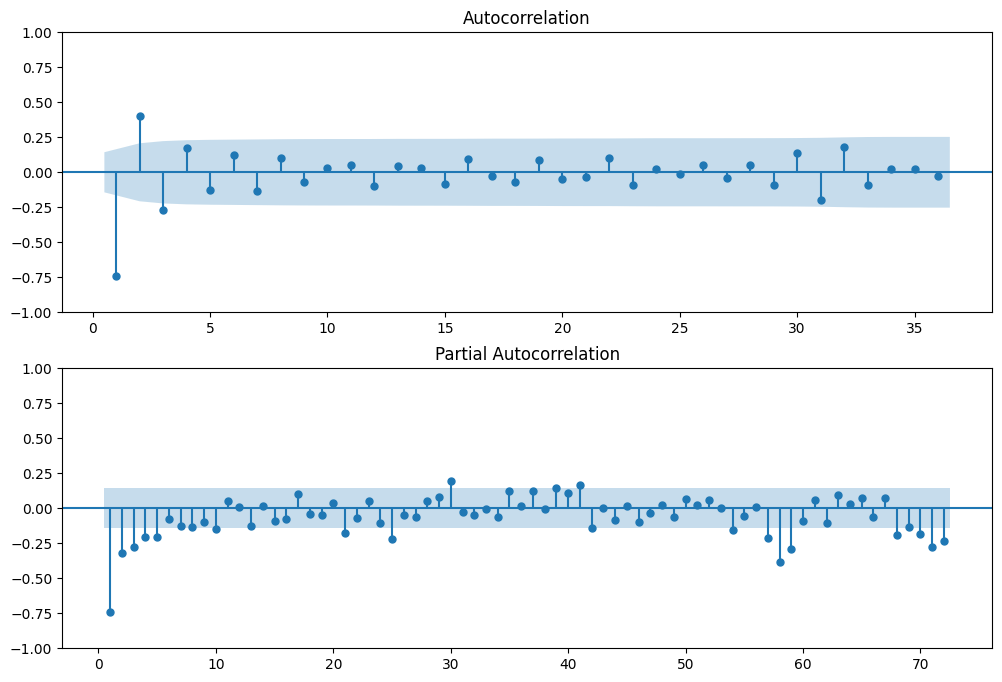

In [ ]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(12,8))

# Plot the ACF of df
plot_acf(diffi, lags=36, zero=False, ax=ax1)

# Plot the PACF of df
plot_pacf(diffi, lags=72, zero=False, ax=ax2)

plt.show()

/usr/local/lib/python3.10/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


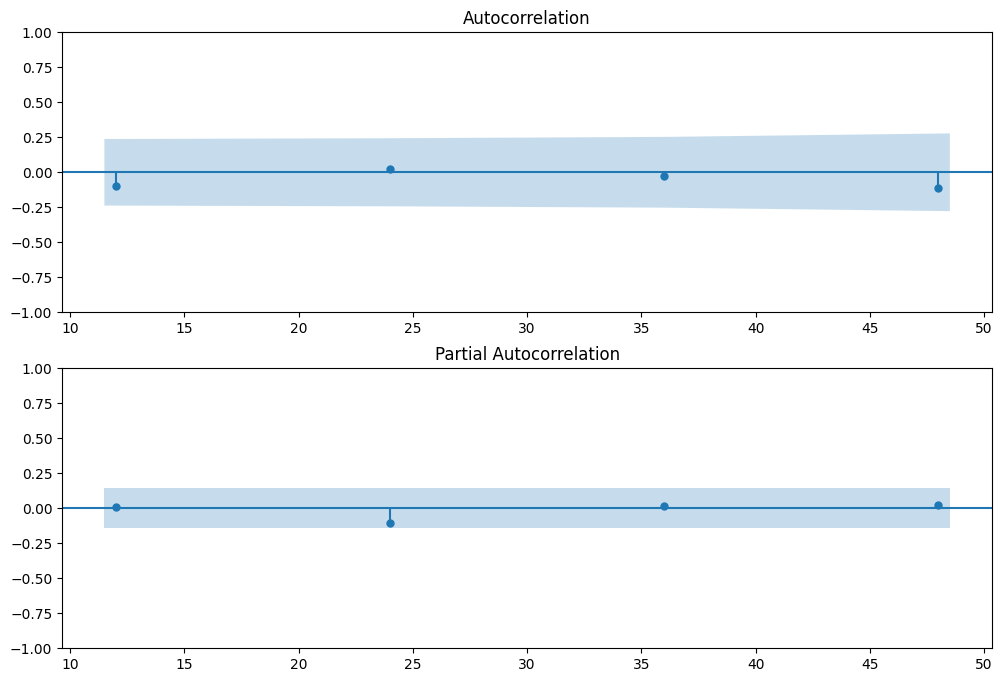

In [ ]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(12,8))

# Plot the ACF of df
plot_acf(diffi, lags=[12,24,36,48], zero=False, ax=ax1)

# Plot the PACF of df
plot_pacf(diffi, lags=[12,24,36,48], zero=False, ax=ax2)

plt.show()

In [ ]:
modelo1i = SARIMAX(traini, order=(3,1,3), seasonal_order=(1,0,0,12))
resultado1i = modelo1i.fit()
resultado1i.summary()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                   Gasolina superior   No. Observations:                  188
Model:             SARIMAX(3, 1, 3)x(1, 0, [], 12)   Log Likelihood               -2400.590
Date:                             Thu, 10 Aug 2023   AIC                           4817.179
Time:                                     00:33:25   BIC                           4843.028
Sample:                                 01-01-2001   HQIC                          4827.653
                                      - 08-01-2016                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.5493      1.721     -0.900      0.368      -4.922       1.823
ar.L2         -0.6045      2.006     -0.301      0.763      -4.536       3.327
ar.L3         -0.0244      0.474     -0.051      0.959      -0.954       0.905
ma.L1          0.3768      1.723      0.219      0.827      -3.000       3.754
ma.L2         -0.6940      0.215     -3.232      0.001      -1.115      -0.273
ma.L3         -0.2088      1.028     -0.203      0.839      -2.223       1.806
ar.S.L12      -0.1192      0.083     -1.439      0.150      -0.282       0.043
sigma2      8.694e+09   2.08e-09   4.18e+18      0.000    8.69e+09    8.69e+09
===================================================================================
Ljung-Box (L1) (Q):                   0.11   Jarque-Bera (JB):                 1.03
Prob(Q):                              0.74   Prob(JB):                         0.60
Heteroskedasticity (H):               1.02   Skew:                             0.18
Prob(H) (two-sided):                  0.95   Kurtosis:                         3.08
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.73e+34. Standard errors may be unstable.
"""

In [ ]:
pred1i = resultado1i.get_prediction(start=5)
pred1ivalues = pred1i.predicted_mean
pred1ic = pred1i.conf_int()
pred1ic

,lower Gasolina superior,upper Gasolina superior
2001-06-01,64495.258873,438395.189120
2001-07-01,82778.793291,454722.697905
2001-08-01,114408.649162,484765.615204
2001-09-01,72041.591494,441498.621331
2001-10-01,80040.693852,449072.663033
...,...,...
2016-04-01,303623.742958,669121.712416
2016-05-01,459661.972496,825159.941954
2016-06-01,370944.483019,736442.452477
2016-07-01,434395.648433,799893.617891


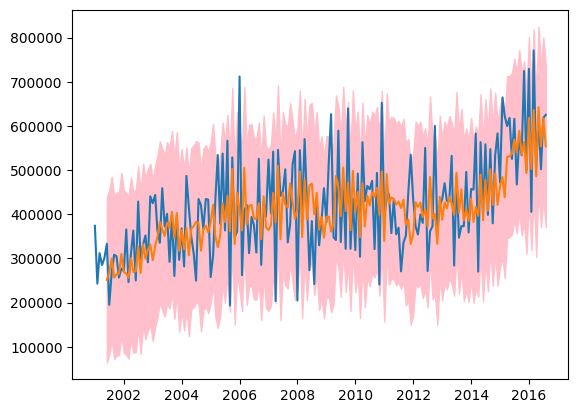

In [ ]:
plt.plot(traini.index,traini, label="Train")
#plt.plot(testi.index, testi, label="Test")
plt.plot(pred1ivalues.index, pred1ivalues, label="Model")
plt.fill_between(pred1ic.index, pred1ic["lower Gasolina superior"], pred1ic["upper Gasolina superior"], color="pink")
plt.show()

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7j46xgr1/otyys5hl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7j46xgr1/g7ei0isp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=17107', 'data', 'file=/tmp/tmp7j46xgr1/otyys5hl.json', 'init=/tmp/tmp7j46xgr1/g7ei0isp.json', 'output', 'file=/tmp/tmp7j46xgr1/prophet_modelthoe2_dp/prophet_model-20230810050419.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
05:04:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
05:04:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


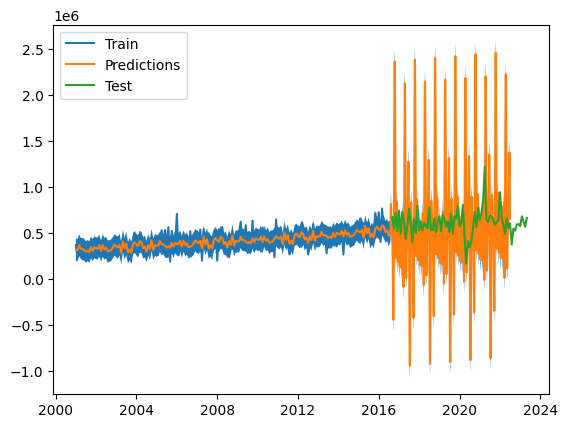

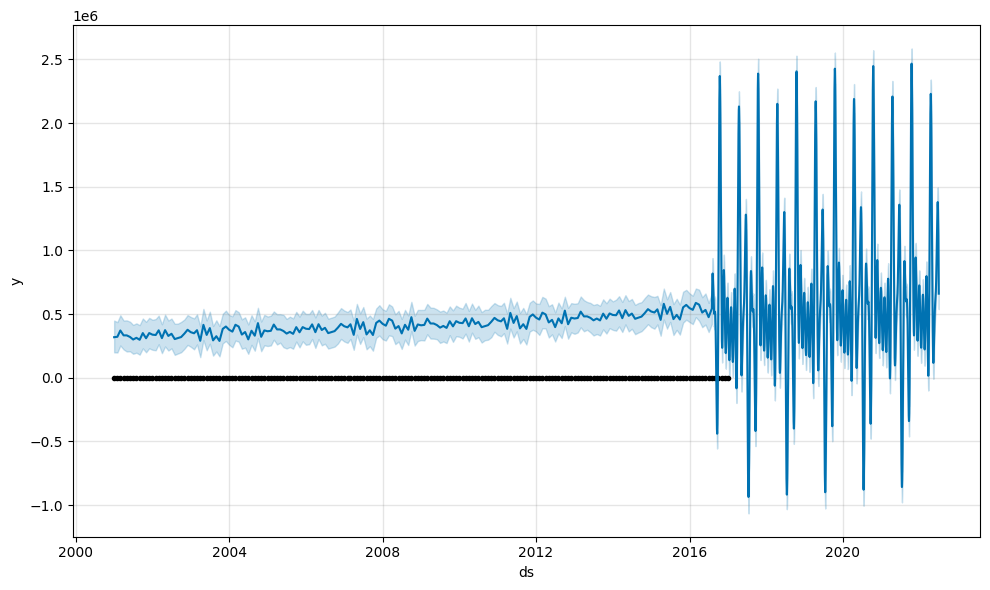

In [ ]:
traini2 = traini.copy()
traini2.reset_index(inplace=True)
traini2.rename(columns={"Fecha":"ds", "Gasolina superior":"y"}, inplace=True)
#traini2
m2 = Prophet()
m2.fit(traini2)
futurep2 = m2.make_future_dataframe(periods = 2160)
forecastp2 = m2.predict(futurep2)
plt.plot(traini.index,traini, label="Train")

plt.plot(forecastp2["ds"], forecastp2["yhat"], label="Predictions")
plt.fill_between(forecastp2["ds"], forecastp2["yhat_lower"], forecastp2["yhat_upper"])
plt.plot(testi.index, testi, label="Test")
plt.legend()
m.plot(forecastp2)
plt.show()

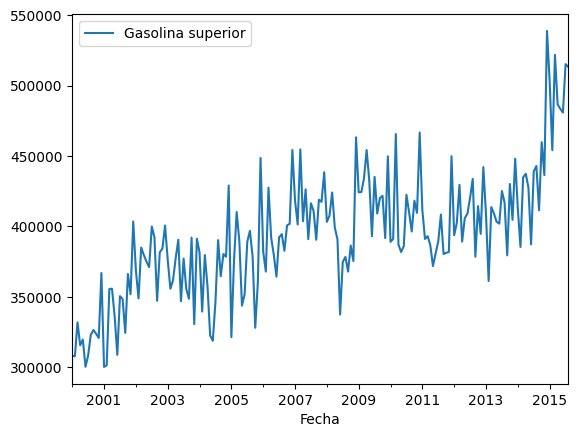

In [ ]:
trainc.plot()
plt.show()

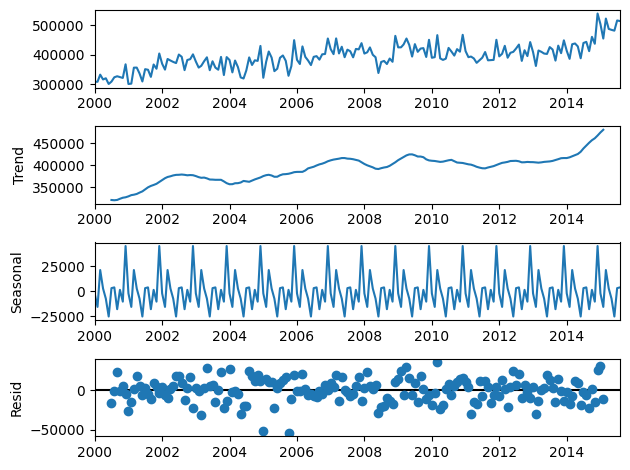

In [ ]:
decompc = seasonal_decompose(trainc)
decompc.plot()
plt.show()

In [ ]:
dfTestc = adfuller(trainc, autolag="AIC")
salidaDfc = pd.Series(dfTestc[0:4], index=['Estadístico de prueba','p-value','# de retardos usados','# de observaciones usadas'])
for key,value in dfTestc[4].items():
        salidaDfc['Critical Value (%s)'%key] = value
print(salidaDfc)

Estadístico de prueba         -0.594243
p-value                        0.872278
# de retardos usados          12.000000
# de observaciones usadas    175.000000
Critical Value (1%)           -3.468280
Critical Value (5%)           -2.878202
Critical Value (10%)          -2.575653
dtype: float64


In [ ]:
diffc = trainc.diff()
diffc.dropna(inplace=True)
dfTestc = adfuller(diffc)
salidaDfc = pd.Series(dfTestc[0:4], index=['Estadístico de prueba','p-value','# de retardos usados','# de observaciones usadas'])
for key,value in dfTestc[4].items():
        salidaDfc['Critical Value (%s)'%key] = value
print(salidaDfc)

Estadístico de prueba         -4.477194
p-value                        0.000216
# de retardos usados          11.000000
# de observaciones usadas    175.000000
Critical Value (1%)           -3.468280
Critical Value (5%)           -2.878202
Critical Value (10%)          -2.575653
dtype: float64


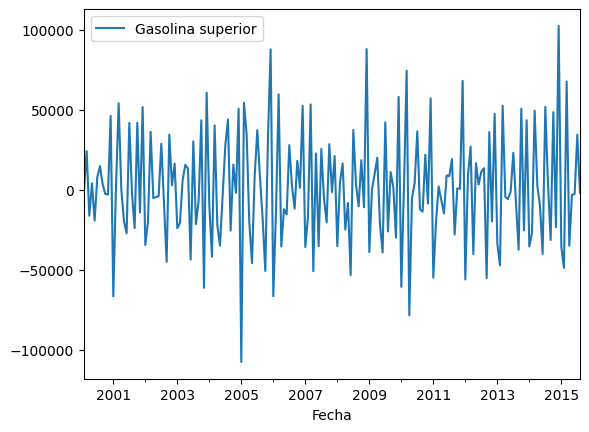

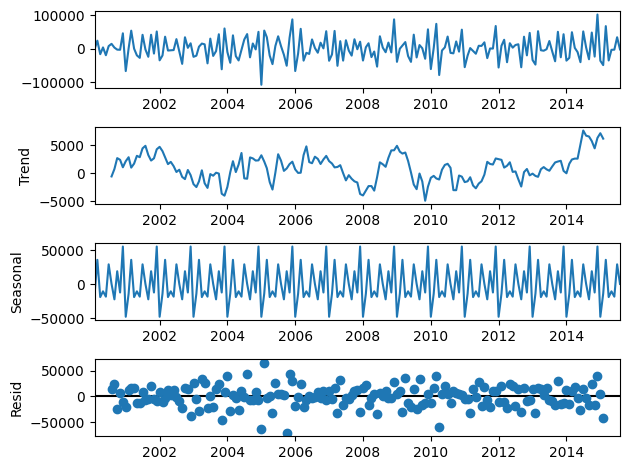

In [ ]:
diffc.plot()
decompc = seasonal_decompose(diffc)
decompc.plot()
plt.show()

/usr/local/lib/python3.10/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


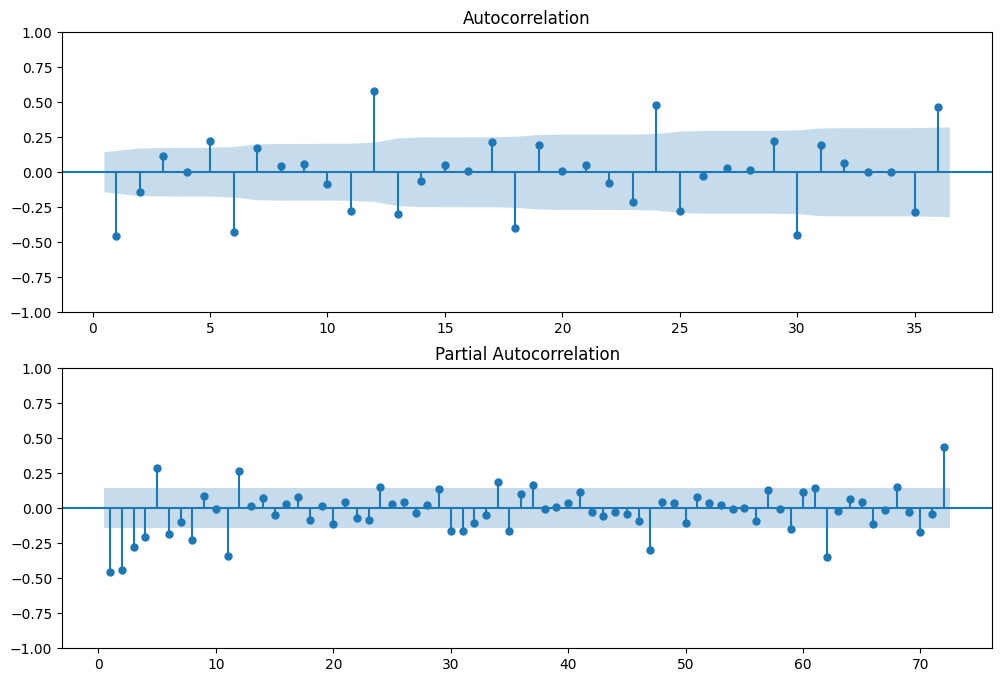

In [ ]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(12,8))

# Plot the ACF of df
plot_acf(diffc, lags=36, zero=False, ax=ax1)

# Plot the PACF of df
plot_pacf(diffc, lags=72, zero=False, ax=ax2)

plt.show()

In [ ]:
model2i = pm.auto_arima(traini,
                        d=1,
                        start_p=1,
                        start_q=1,
                        max_p=5,
                        max_q=5,
                        seasonal=True,
                        m=12,
                        D=1,
                        start_P=1,
                        start_Q=1,
                        max_P=5,
                        max_Q=5,
                        information_criterion="aic",
                        trace=True,
                        error_action="ignore",
                        stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=4587.439, Time=0.89 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=4822.641, Time=0.09 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=4654.088, Time=0.50 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=4623.516, Time=0.68 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=4587.581, Time=0.92 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=4609.167, Time=0.79 sec
 ARIMA(1,1,1)(2,1,1)[12]             : AIC=4589.193, Time=1.90 sec
 ARIMA(1,1,1)(1,1,2)[12]             : AIC=4589.120, Time=4.17 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=4653.987, Time=0.59 sec
 ARIMA(1,1,1)(0,1,2)[12]             : AIC=4587.209, Time=1.76 sec
 ARIMA(1,1,1)(0,1,3)[12]             : AIC=4589.131, Time=2.43 sec
 ARIMA(1,1,1)(1,1,3)[12]             : AIC=4591.107, Time=2.04 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=4624.391, Time=0.77 sec
 ARIMA(1,1,0)(0,1,2)[12]             : AIC=4622.366, Time=0.78 sec
 ARIMA(2,1,1)(0,1,2

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  188
Model:             SARIMAX(1, 1, 2)x(0, 1, 2, 12)   Log Likelihood               -2283.799
Date:                            Thu, 10 Aug 2023   AIC                           4579.599
Time:                                    03:03:29   BIC                           4598.588
Sample:                                01-01-2001   HQIC                          4587.301
                                     - 08-01-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6496      0.282     -2.303      0.021      -1.202      -0.097
ma.L1         -0.4807      0.333   

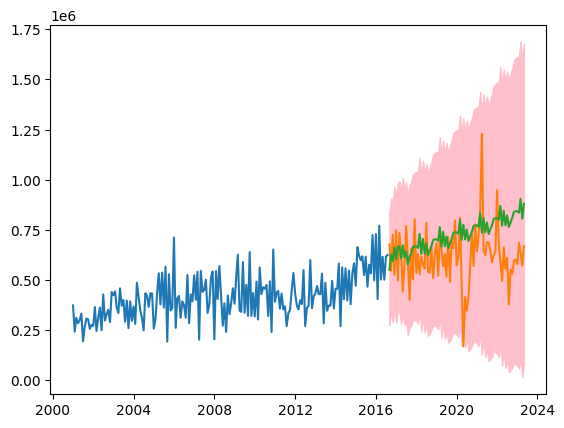

In [ ]:
print(model2i.summary())
#print(model2p.plot_diagnostics())
pred2i, conf_int2i = model2i.predict(n_periods=len(testi), return_conf_int=True)
plt.plot(traini.index,traini, label="Train")
plt.plot(testi.index, testi, label="Test")
plt.plot(testi.index, pred2i, label="Model")
plt.fill_between(testi.index, conf_int2i[:,0], conf_int2i[:,1], color="pink")
plt.show()

In [ ]:
model2c = pm.auto_arima(trainc,
                        d=1,
                        start_p=1,
                        start_q=1,
                        max_p=5,
                        max_q=5,
                        seasonal=True,
                        m=12,
                        D=1,
                        start_P=1,
                        start_Q=1,
                        max_P=5,
                        max_Q=5,
                        information_criterion="aic",
                        trace=True,
                        error_action="ignore",
                        stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=4042.194, Time=0.77 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=4106.253, Time=0.05 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=4073.810, Time=0.26 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=4047.078, Time=0.28 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=4046.935, Time=0.51 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=4064.212, Time=0.36 sec
 ARIMA(1,1,1)(2,1,1)[12]             : AIC=4043.328, Time=2.42 sec
 ARIMA(1,1,1)(1,1,2)[12]             : AIC=4043.537, Time=2.03 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=4088.435, Time=0.16 sec
 ARIMA(1,1,1)(0,1,2)[12]             : AIC=4041.619, Time=1.31 sec
 ARIMA(1,1,1)(0,1,3)[12]             : AIC=4043.480, Time=2.50 sec
 ARIMA(1,1,1)(1,1,3)[12]             : AIC=4044.352, Time=5.56 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=4041.542, Time=1.16 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=4043.477, Time=1.34 sec
 ARIMA(0,1,1)(0,1,3

In [ ]:
print(model2c.summary())
#print(model2p.plot_diagnostics())
pred2c, conf_int2c = model2c.predict(n_periods=len(testc), return_conf_int=True)
plt.plot(trainc.index,trainc, label="Train")
plt.plot(testc.index, testc, label="Test")
plt.plot(testc.index, pred2c, label="Model")
plt.fill_between(testc.index, conf_int2c[:,0], conf_int2c[:,1], color="pink")
plt.legend()
plt.show()

NameError: ignored

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7j46xgr1/wr9esaxm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7j46xgr1/rqlt1tia.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=4185', 'data', 'file=/tmp/tmp7j46xgr1/wr9esaxm.json', 'init=/tmp/tmp7j46xgr1/rqlt1tia.json', 'output', 'file=/tmp/tmp7j46xgr1/prophet_model09788d0f/prophet_model-20230810050448.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
05:04:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
05:04:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


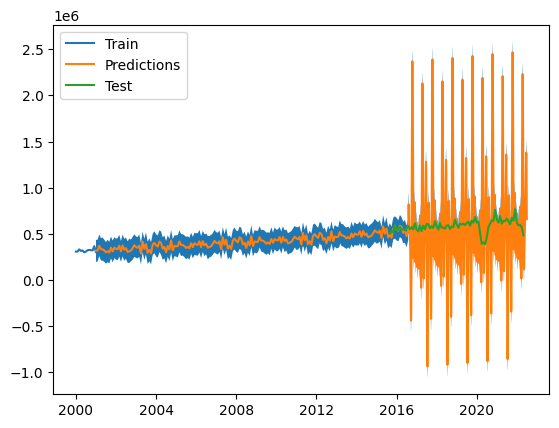

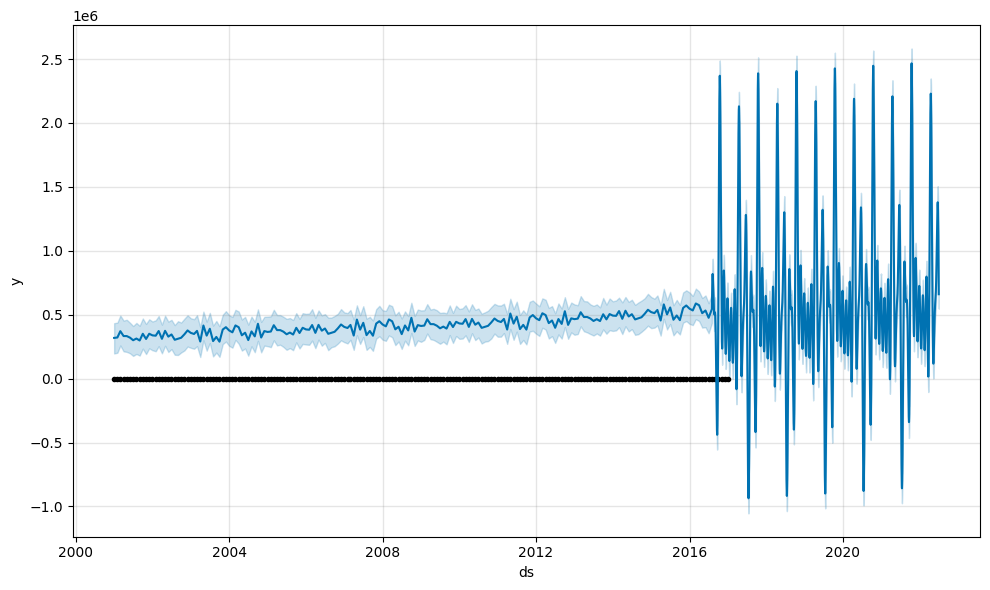

In [ ]:
trainc2 = trainc.copy()
trainc2.reset_index(inplace=True)
trainc2.rename(columns={"Fecha":"ds", "Gasolina superior":"y"}, inplace=True)
#traini2
m3 = Prophet()
m3.fit(traini2)
futurep3 = m3.make_future_dataframe(periods = 2160)
forecastp3 = m3.predict(futurep3)
plt.plot(trainc.index,trainc, label="Train")

plt.plot(forecastp3["ds"], forecastp3["yhat"], label="Predictions")
plt.fill_between(forecastp3["ds"], forecastp3["yhat_lower"], forecastp3["yhat_upper"])
plt.plot(testc.index, testc, label="Test")
plt.legend()
m.plot(forecastp3)
plt.show()

In [ ]:
trainc

,Gasolina superior
Fecha,
2000-01-01,308156.82
2000-02-01,307766.31
2000-03-01,331910.29
2000-04-01,315648.08
2000-05-01,319667.97
...,...
2015-04-01,486779.41
2015-05-01,483594.83
2015-06-01,480892.11
